In [ ]:
import numpy as np
import qutip as qt
import scipy as sp
from scipy import linalg
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random
from matplotlib import rc
from cycler import cycler
from cmt import *

rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':25})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
#options = qt.Options(rhs_reuse=True)

In [ ]:
rank = 2 # rank of hamiltonian
kets = [qt.basis(2,i) for i in range(rank)]
projs = [qt.ket2dm(ket) for ket in kets]
c_ops =[]
psi0 = qt.fock(2,0)

e = 1.6e-19 #coulomb
h = 6.63e-34 *1e12/ e #eV ps
hbar = 1
hbar_eV = 6.582e-16 * 1e12 #eV ps
c = 3e8 * 1e-10 # cm/ps

N_atoms = int(1e5)

T = 300 #K temperature of cloud
m = 2*9.1e-31 #kg
k = 1.38e-23 # [J K^-1]
std_deviation = np.sqrt(k*T/m) #standard deviation of gaussian
amplitude = np.sqrt(m/(2*np.pi*k*T))
N_bins = 267 #calculated such that 1 bin is the equivalent of 1 unit of photon momentum for Ps


velocity_bins = np.linspace(-2e5,2e5,N_bins) #m/s
populations = np.zeros(N_bins)
for i in range(N_bins-1):
    populations[i] = sp.integrate.quad(lambda v: amplitude*np.exp(-v**2/(2*std_deviation**2))*1e5,velocity_bins[i],velocity_bins[i+1])[0]
velocity_bins = velocity_bins*1e-10 #cm/ps

endTime =  20 #ps 
mass_ps = 1.022e6 # eV/ c^2 
wavelength = 243e-7 #cm
wavenumber = 2*np.pi/wavelength
momentum_per_photon = hbar_eV*wavenumber #eV ps cm^-1
velocity_change_per_photon = momentum_per_photon / mass_ps *c**2 #  cm/ps
print(velocity_change_per_photon*1e10, "m/s")
energy_splitting =  h*c/wavelength
omega0 = energy_splitting / hbar / hbar_eV# radians ps^-1
period = wavelength/c

binwidth = 2*np.pi/omega0*1000
N_time = int(endTime/binwidth)
tlist = np.linspace(0,endTime,N_time)

pulse_duration = 10 #ps
tcentre = 10 #ps
tlist_centre = np.full(N_time,tcentre)


In [ ]:
def evolve(velocity_bins,initial_states,pulse_kwargs):
    omega0 = pulse_kwargs["omega0"]
    detuning = pulse_kwargs["detuning"]
    chirp= pulse_kwargs["chirp"]
    rabi0= pulse_kwargs["rabi0"]
    pulse_duration = pulse_kwargs["pulse_duration"]
    direction = pulse_kwargs["direction"]
    
    
    rabi = lambda t, args: rabi0 * np.exp(-4*np.log(2)*(t-tcentre)**2/pulse_duration**2)
    
    final_states = []
    for i in range(N_bins):
        vel = velocity_bins[i]
        psi0 = qt.Qobj([[ initial_states[i][0] ],[ initial_states[i][1] ]])

        H0 = hbar*qt.Qobj([[0,0],[0,omega0*direction*vel/c +detuning*(1+direction*vel/c)]])
        H_chirp = hbar*qt.Qobj([[0,0],[0,chirp*(1+direction*vel/c)]])
        H_transition = 0.5*hbar*qt.sigmax()
        H = [H0,[H_chirp,tlist-tlist_centre],[H_transition,rabi]]

        result = qt.mesolve(H, psi0,tlist,c_ops,e_ops=projs)
        final_states.append([result.expect[0][-1],result.expect[1][-1]])
    
    final_states = np.asarray(final_states)
    return final_states 

def update_states(initial_states, transitions, momentum):
    ground = np.asarray([initial_states[i][0] for i in range(N_bins)])
    excited = np.asarray([initial_states[i][1] for i in range(N_bins)])


    new_pops = np.zeros((N_bins,2))
    for i in range(2,N_bins-2):
        new_pops[i][0] = ground[i]*(1-transitions[i][0]) + excited[i+momentum]*transitions[i+momentum][1]
        new_pops[i][1] =  excited[i]*(1-transitions[i][1]) + ground[i-momentum]*transitions[i-momentum][0]
        
    return new_pops

In [117]:
# also another reason to care about chirp is that it allows us to dramatically increase the laser bandwidth and still keep the same pulse duration,
# which is important due to the annihilation time of positronium

states0 = np.asarray([(1,0) if velocity_bins[i] <= 0 else (0,1) for i in range(N_bins)]) # instantiate states in ground state


flip_pulse = {"rabi0" : 2*np.pi*(1000e-3), "detuning": 0,"chirp" : 2*np.pi*(200e-3),"pulse_duration" : 10 , "omega0" : energy_splitting / hbar / hbar_eV,"direction":+1}
N_cycles = 1

#transitions = evolve(velocity_bins,states0,flip_pulse)
new_pops = np.asarray([(states0[i][0]*populations[i], states0[i][1]*populations[i])  for i in range(N_bins)])
print(np.sum(new_pops))
direction = 1
for i in range(N_cycles):
    temp_pops = new_pops
    for j in range(1,N_bins-1):
        # assume population is perfectly inverted
        new_pops[j][0] = temp_pops[j+direction][1]
        new_pops[j][1] = temp_pops[j-direction][0]
    
    direction = -direction

99997.25186719955


In [ ]:
""" for i in range(N_bins):
    if states[i][0] + states[i][1] > 1 or states[i][0] + states[i][1] < 0 :
        print(states[i][0] + states[i][1])
 """

99997.25186719955
97482.40553063506


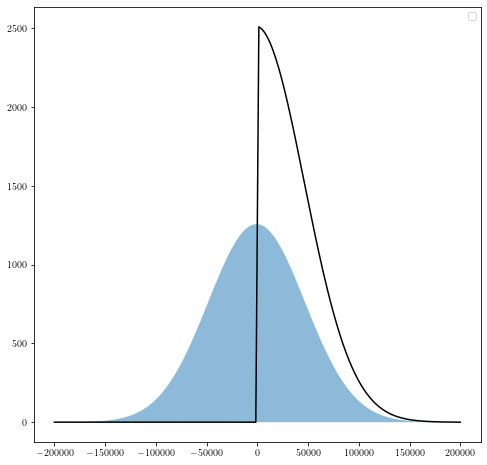

In [109]:
total = np.sum(new_pops,axis=1)
total0 = np.sum(np.asarray([(states0[i][0]*populations[i], states0[i][1]*populations[i])  for i in range(N_bins)]),axis=1)
print(np.sum(total0))
print(np.sum(total))
fig = plt.figure(figsize=(8,8))
plt.fill_between(velocity_bins*1e10,0,populations,alpha=0.5)
plt.plot(velocity_bins*1e10,total,color="black")
plt.legend()
plt.show()